# Part 3: Enhancement

In this section, strategies have been designed to improve upon the previous RNN model built. 

### Import libraries

In [ ]:
# Installing packages
!pip install datasets
!pip install gensim
!pip install nlpaug transformers
!pip install tf_keras
!pip install tensorflow
!pip install ktrain
!pip install fasttext

^C



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for numpy>=1.18.5 from https://files.pythonhosted.org/packages/d8/ec/ebef2f7d7c28503f958f0f8b992e7ce606fb74f9e891199329d5f5f87404/numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata
  Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-win_amd64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
tensorflow-intel 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C
Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for numpy<2.1.0,>=1.26.0 from https://files.pythonhosted.org/packages/eb/57/3a3f14d3a759dcf9bf6e9eda905794726b758819df4663f217d658a58695/numpy-2.0.2-cp311-cp311-win_amd64.whl.metadata
  Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.0.2-cp311-cp311-win_amd64.whl (15.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
tables 3.8.0 requires cython>=0.29.21, which is not installed.
pyfume 0.3.4 requires numpy==1.24.4, but you have numpy 2.0.2 which is incompatible.
numba 0.57.0 requires numpy<1.25,>=1.21, but you have numpy 2.0.2 which is incompatible.
scipy 1.10.1 requires numpy<1.27.0,>=1.19.5, but you have numpy 2.0.2 which is incompatible.

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


^C


In [29]:
# Importing necessary libraries

# Gensim library for NLP utilities
import gensim
from gensim.utils import simple_preprocess
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import gensim.downloader as api


# NumPy for numerical computations
import numpy as np

# Hugging Face Datasets for dataset loading
from datasets import load_dataset

# Matplotlib for data visualization
import matplotlib.pyplot as plt

# TensorFlow and Keras for model building and training
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (
    RepeatVector, Layer, Reshape, Embedding, SimpleRNN, LSTM, GRU, Conv1D,
    Dropout, Softmax, Permute, Multiply, Lambda, Concatenate, Masking,
    Bidirectional, Dense, Attention, Input, GlobalAveragePooling1D,
    GlobalMaxPooling1D, Flatten
)
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow import reduce_sum

# OS for setting environmental variable
import os

# For data augmentation
from sklearn.utils import shuffle
import random
from nltk.corpus import wordnet

In [2]:
# Set env variable to use legacy Keras API for compatibility
os.environ["TF_USE_LEGACY_KERAS"]="1"

### Load and Process Data

In [3]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Preprocess the data
def preprocess(dataset):
    
    processed_sentences = []

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Append the processed sentence to the list
        processed_sentences.append(processed_sentence)

    return processed_sentences

processed_train = preprocess(train_dataset)
processed_val = preprocess(validation_dataset)
processed_test = preprocess(test_dataset)

# Find max sentence length
def find_max_sentence_length(dataset):
    max_sentence_length = 0

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Calculate the longest sentence length for later use
        if (len(processed_sentence) > max_sentence_length):
                max_sentence_length = len(processed_sentence)

    return max_sentence_length

max_sentence_length = find_max_sentence_length(train_dataset)

# Extract labels
def label(dataset):
    labels = dataset['label']
    labels = np.array(labels)
    return labels

train_labels = label(train_dataset)
val_labels = label(validation_dataset)
test_labels = label(test_dataset)

In [41]:
### TESTING
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Preprocess the data
def preprocess(dataset):
    
    processed_sentences = []

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Append the processed sentence to the list
        processed_sentences.append(processed_sentence)

    return processed_sentences

processed_train = preprocess(train_dataset)
processed_val = preprocess(validation_dataset)
processed_test = preprocess(test_dataset)

# Find max sentence length
def find_max_sentence_length(dataset):
    max_sentence_length = 0

    for text in dataset['text']:
        # Preprocess the sentence (tokenisation, lowercasing, removing punctuation)
        processed_sentence = simple_preprocess(text)

        # Calculate the longest sentence length for later use
        if (len(processed_sentence) > max_sentence_length):
                max_sentence_length = len(processed_sentence)

    return max_sentence_length

max_sentence_length = find_max_sentence_length(train_dataset)

# Extract labels
def label(dataset):
    labels = dataset['label']
    labels = np.array(labels)
    return labels

train_labels = label(train_dataset)
val_labels = label(validation_dataset)
test_labels = label(test_dataset)

### Tokenize and Pad Sequences

In [4]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(processed_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(processed_train)
val_sequences = tokenizer.texts_to_sequences(processed_val)
test_sequences = tokenizer.texts_to_sequences(processed_test)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_sentence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sentence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

### Load Pre-trained Word Embeddings - Without OOV handling

In [5]:
# Save desired pre-trained gensim model (based on Part 1)

# Specify path to save models
save_paths ={
    'glove_wiki_300': './glove_wiki_gigaword_300.model',
}

# Download and save model, will take up to few minutes
glove_wiki_300 = api.load('glove-wiki-gigaword-300')
glove_wiki_300.save(save_paths['glove_wiki_300'])

In [6]:
# Load pre-trained word embeddings
glove_wiki_300 = KeyedVectors.load('./glove_wiki_gigaword_300.model')

# Create embedding matrix
train_vocab = set(word for sentence in processed_train for word in sentence)
vocab_size = len(train_vocab)
embedding_dim = glove_wiki_300.vector_size
train_vocab_size = len(train_vocab) + 1

# Populate the embedding matrix
embedding_matrix = np.zeros((train_vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in glove_wiki_300:
        embedding_matrix[idx] = glove_wiki_300[word]
    else:
        # Use zero vector for OOV words
        embedding_matrix[idx] = np.zeros(embedding_dim)
    

## Part 3.1: Defining the Enhanced Embedding Layer 

This embedding layer will be trainable, allowing it to be updated during training.

To allow the word embeddings to be updated during the training, <b>trainable is set to True</b>, allowing the embeddings to be adjusted as part of the model's training process such that they are learnable parameters instead of fixed ones. 

In [7]:
def enhanced_embedding_layer(vocab_size, embedding_dim, embedding_matrix):
    return Embedding(input_dim=vocab_size,
                     output_dim=embedding_dim,
                     weights=[embedding_matrix],
                     trainable=True, # Allows embeddings to be updated
                     mask_zero=True) # Useful for handling padding

### Implementing the RNN model used in Part 2 with Enhanced Embedding Layer

In [8]:
def build_rnn_model(train_vocab_size, embedding_dim, embedding_matrix, hidden_neurons=60):
    model = Sequential()

    # Use the enhanced embedding layer with trainable embeddings
    model.add(enhanced_embedding_layer(train_vocab_size, embedding_dim, embedding_matrix))

    # Add the SimpleRNN layer
    model.add(SimpleRNN(units=hidden_neurons))

    # Output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
    
    return model
    

### Instantiating the Model and Training it

In [9]:
# Instantiate the RNN model with updated embeddings
rnn_model = build_rnn_model(train_vocab_size, embedding_dim, embedding_matrix, hidden_neurons=60)

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = rnn_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.5494 - loss: 0.7009 - val_accuracy: 0.7045 - val_loss: 0.5782
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7504 - loss: 0.5136 - val_accuracy: 0.7373 - val_loss: 0.5198
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8145 - loss: 0.4201 - val_accuracy: 0.7617 - val_loss: 0.5022
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8616 - loss: 0.3403 - val_accuracy: 0.7617 - val_loss: 0.5197
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9023 - loss: 0.2593 - val_accuracy: 0.7767 - val_loss: 0.5086
Epoch 6/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9296 - loss: 0.2073 - val_accuracy: 0.7617 - val_loss: 0.5570


### Evaluating the Model on the Test Set

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7343 - loss: 0.5370
Test Accuracy: 0.7795497179031372
Test Loss: 0.4754737913608551


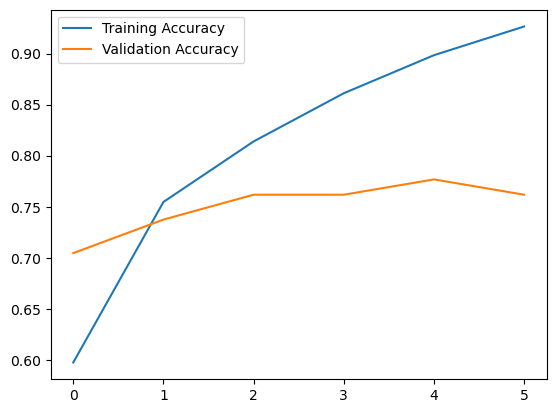

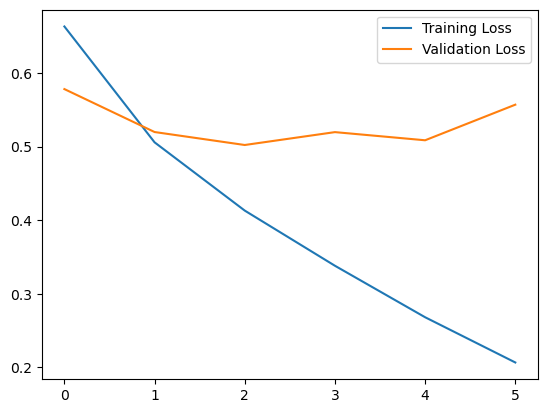

In [10]:
# Evaluate on the test set
test_loss, test_accuracy = rnn_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Upon updating the modifying the embedding layer to allow word embeddings to be updated, the `test accuracy is 0.77` while the `test loss is 0.47`.

## Part 3.2 Creating embedding matrix - With OOV handling

In this part, pre-trained FastText embeddings are loaded instead of GloVe and the embedding handling is modified. FastText represents each word as subword units, which helps generate vectors for OOV words based on their components, effectively reducing the impact of unknown words.

### Loading embeddings and creating embedding matrix with OOV handling

In [11]:
# Load pre-trained FastText embeddings instead of GloVe
fasttext_model = KeyedVectors.load_word2vec_format('./wiki.en.vec', binary=False)

In [12]:
# Create embedding matrix
train_vocab = set(word for sentence in processed_train for word in sentence)
embedding_dim = fasttext_model.vector_size
train_vocab_size = len(train_vocab) + 1

# Creating embedding with OOV handling
embedding_matrix = np.zeros((train_vocab_size, embedding_dim))
        
for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:  # Skip words beyond the tokenizer's vocabulary limit
        continue
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]
    else:
        # FastText can generate embeddings for OOV words by subword decomposition
        embedding_matrix[idx] = fasttext_model[word] if word in fasttext_model else np.random.normal(size=(embedding_dim,))

### Instantiating and Training Model with updated embeddings and special OOV handling

In [13]:
# Instantiate the RNN model with updated embeddings
rnn_model = build_rnn_model(train_vocab_size, embedding_dim, embedding_matrix, hidden_neurons=60)

# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = rnn_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5508 - loss: 0.6872 - val_accuracy: 0.6989 - val_loss: 0.5793
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7694 - loss: 0.4887 - val_accuracy: 0.7364 - val_loss: 0.5235
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step - accuracy: 0.8359 - loss: 0.3817 - val_accuracy: 0.7589 - val_loss: 0.5102
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.8893 - loss: 0.2859 - val_accuracy: 0.7627 - val_loss: 0.5289
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9336 - loss: 0.1981 - val_accuracy: 0.7739 - val_loss: 0.5663
Epoch 6/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - accuracy: 0.9613 - loss: 0.1314 - val_accuracy: 0.7702 - val_loss: 0.6675


### Evaluating the Model on the Test Set

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7954 - loss: 0.4372
Test Accuracy: 0.7720450162887573
Test Loss: 0.4801204800605774


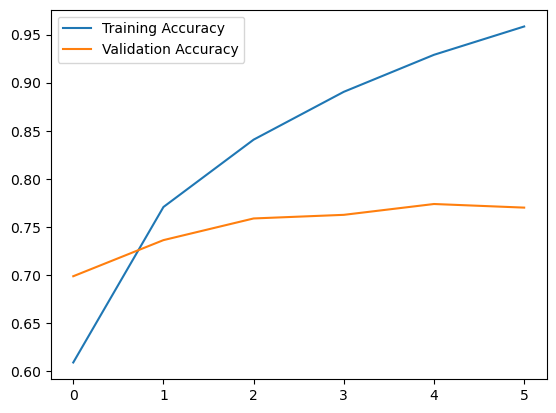

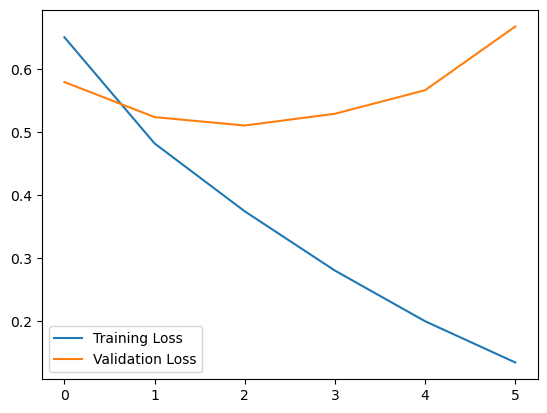

In [14]:
# Evaluate on the test set
test_loss, test_accuracy = rnn_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Upon applying the FastText model to mitigate the influence of OOV words, the `test accuracy is 0.77` while the `test loss is 0.48`. 

## Part 3.3: Implement the Enhanced Models with BiLSTM and BiGRU architechtures

### Defining and Instantiating the BiLSTM Model

Defining a stacked, bi-directional LSTM with 2 stacked LSTM layers, each operating in both directions.

In [15]:
def build_bilstm_model(train_vocab_size, embedding_dim, embedding_matrix, hidden_units=60):
    model = Sequential([
        enhanced_embedding_layer(train_vocab_size, embedding_dim, embedding_matrix),
        Bidirectional(LSTM(hidden_units, return_sequences=True)),
        Bidirectional(LSTM(hidden_units)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
    return model

# Instantiate and summarize the model
bilstm_model = build_bilstm_model(train_vocab_size, embedding_dim, embedding_matrix)
bilstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     4,886,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,700 (18.64 MB)

 Trainable params: 4,886,700 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluation of Model

Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 30s 74ms/step - accuracy: 0.6160 - loss: 0.6410 - val_accuracy: 0.7505 - val_loss: 0.5288
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.7986 - loss: 0.4329 - val_accuracy: 0.7805 - val_loss: 0.4747
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.8518 - loss: 0.3364 - val_accuracy: 0.7889 - val_loss: 0.4784
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 75ms/step - accuracy: 0.9069 - loss: 0.2368 - val_accuracy: 0.7880 - val_loss: 0.5535
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9409 - loss: 0.1598 - val_accuracy: 0.7842 - val_loss: 0.6378
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8081 - loss: 0.3949
Test Accuracy: 0.7757973670959473
Test Loss: 0.4567137360572815


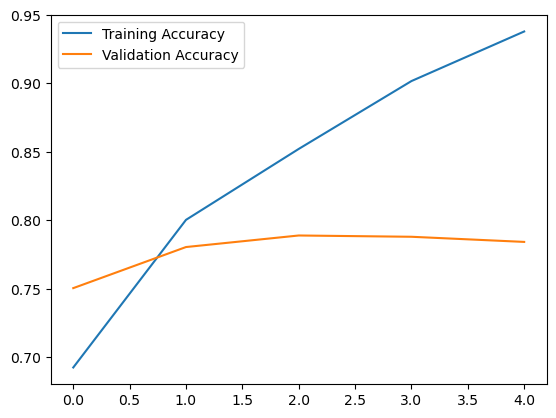

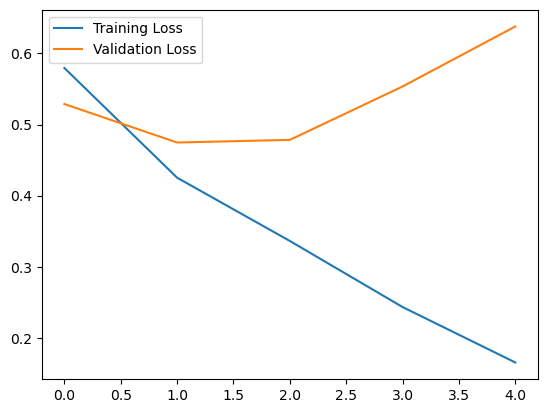

In [16]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = bilstm_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_accuracy = bilstm_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Keeping the previous adjustments and replacing the simple RNN model with the biLSTM model, the `test accuracy is 0.77` and the `test loss is 0.45`. 

### Defining and Instantiating theBiGRU Model

Defining a stacked, bi-directional GRU with 2 GRU layers, where each layer processes the input in both forward and backward directions.

In [17]:
def build_bigru_model(train_vocab_size, embedding_dim, embedding_matrix, hidden_units=60):
    model = Sequential([
        enhanced_embedding_layer(train_vocab_size, embedding_dim, embedding_matrix),
        Bidirectional(GRU(hidden_units, return_sequences=True)),
        Bidirectional(GRU(hidden_units)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
    return model

# Instantiate and summarize the model
bigru_model = build_bigru_model(train_vocab_size, embedding_dim, embedding_matrix)
bigru_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     4,886,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,700 (18.64 MB)

 Trainable params: 4,886,700 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluation of Model

Epoch 1/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - accuracy: 0.6168 - loss: 0.6495 - val_accuracy: 0.7514 - val_loss: 0.4941
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.8020 - loss: 0.4273 - val_accuracy: 0.7767 - val_loss: 0.4727
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8498 - loss: 0.3301 - val_accuracy: 0.7852 - val_loss: 0.4757
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.8992 - loss: 0.2531 - val_accuracy: 0.7861 - val_loss: 0.5065
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.9344 - loss: 0.1771 - val_accuracy: 0.7739 - val_loss: 0.5875
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7950 - loss: 0.3993
Test Accuracy: 0.7814258933067322
Test Loss: 0.4454198181629181


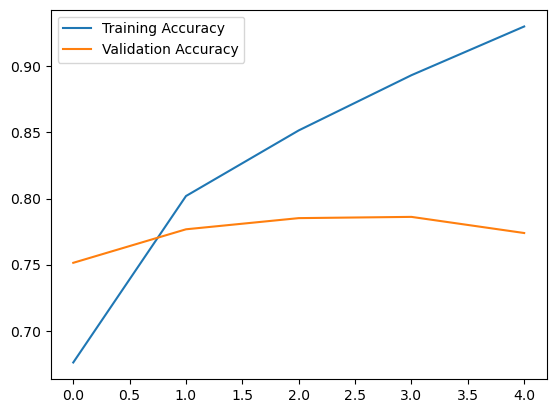

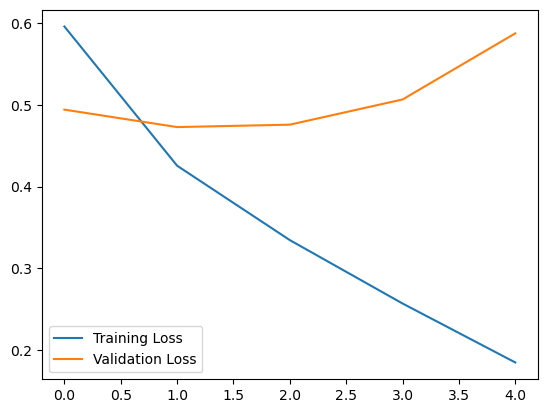

In [18]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = bigru_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_accuracy = bigru_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Keeping the previous adjustments and replacing the simple RNN model with the biGRU model, the `test accuracy is 0.78` and the `test loss is 0.45`. 

## Part 3.4: Implement the Enhanced Models with CNN architechture

In this part, a CNN with a <b>Conv1D layer</b> is defined for processing text sequences, followed by <b>GlobalMaxPoolingID layer</b> to reduce dimensionality. 

This model helps to cature local patterns in the text such as key phrases or specific word combinations, which are useful for sentiment analysis.

In [19]:
def build_cnn_model(train_vocab_size, embedding_dim, embedding_matrix, filters=128, kernel_size=5):
    model = Sequential([
        enhanced_embedding_layer(train_vocab_size, embedding_dim, embedding_matrix),
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=2e-4), metrics=['accuracy'])
    return model

# Instantiate and summarize the model
cnn_model = build_cnn_model(train_vocab_size, embedding_dim, embedding_matrix)
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     4,886,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,886,700 (18.64 MB)

 Trainable params: 4,886,700 (18.64 MB)

 Non-trainable params: 0 (0.00 B)

### Training and Evaluation of Each Model

Epoch 1/15


C:\Users\Pareena\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


267/267 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5623 - loss: 0.6901 - val_accuracy: 0.7158 - val_loss: 0.5920
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7370 - loss: 0.5542 - val_accuracy: 0.7458 - val_loss: 0.5365
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7929 - loss: 0.4677 - val_accuracy: 0.7608 - val_loss: 0.5043
Epoch 4/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.8424 - loss: 0.3923 - val_accuracy: 0.7795 - val_loss: 0.4727
Epoch 5/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.8816 - loss: 0.3189 - val_accuracy: 0.7889 - val_loss: 0.4572
Epoch 6/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9070 - loss: 0.2757 - val_accuracy: 0.7805 - val_loss: 0.4698
Epoch 7/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.9272 - loss: 0.2251 - val_accuracy: 0.7889 - val_loss: 0.4551
Epoch 8/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9489 - loss: 0.1835 - val_accurac

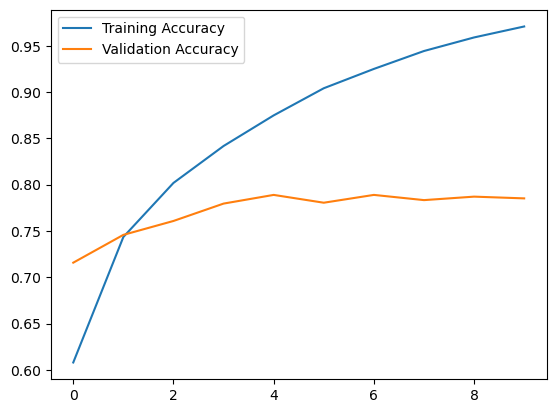

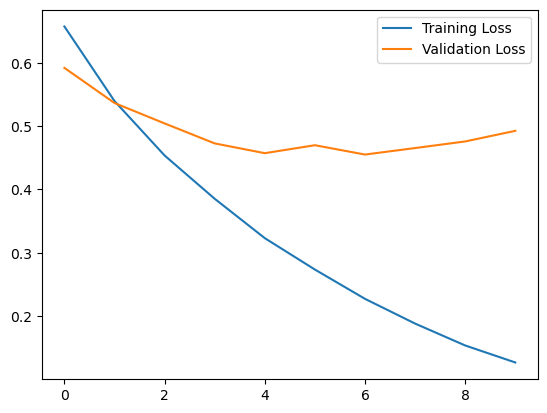

In [20]:
# Define early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = cnn_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

# Evaluate on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Keeping the previous adjustments and replacing the simple RNN model with the biGRU model, the `test accuracy is 0.78` and the `test loss is 0.43`.

## Part 3.5: Improvement Strategy - Data Augmentation

In this part, `data augmentation techniques` are applied to:
- `Improves Generalization`: By increasing the variability in training data, the model learns to generalize better, reducing overfitting.
- `Enhances Robustness`: Data augmentation exposes the model to diverse forms of input, making it more robust to variations and noise in real-world data.
- `Increases Data Size`: With limited data, data augmentation effectively increases the size of the training dataset, allowing the model to learn better patterns.
- `Reduces Overfitting`: Especially with complex models like BiLSTM, data augmentation can prevent the model from memorizing training examples, resulting in improved performance on unseen data.

Using data augmentation can significantly enhance the model’s performance by helping it learn robust and generalized representations of the data.

### Preparing and Processing Data

In [32]:
# Load pre-trained FastText embeddings instead of GloVe
fasttext_model = KeyedVectors.load_word2vec_format('./wiki.en.vec', binary=False)

Epoch 1/15


C:\Users\Pareena\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'conv1d_4' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


1333/1333 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step - accuracy: 0.6704 - loss: 0.5950 - val_accuracy: 0.7767 - val_loss: 0.4750
Epoch 2/15
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 63s 47ms/step - accuracy: 0.8749 - loss: 0.3137 - val_accuracy: 0.7786 - val_loss: 0.4730
Epoch 3/15
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 64s 48ms/step - accuracy: 0.9413 - loss: 0.1733 - val_accuracy: 0.7861 - val_loss: 0.5666
Epoch 4/15
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 62s 46ms/step - accuracy: 0.9711 - loss: 0.0988 - val_accuracy: 0.7908 - val_loss: 0.6741
Epoch 5/15
1333/1333 ━━━━━━━━━━━━━━━━━━━━ 62s 46ms/step - accuracy: 0.9839 - loss: 0.0593 - val_accuracy: 0.7777 - val_loss: 0.7879
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7621 - loss: 0.4692
Test Accuracy: 0.7804877758026123
Test Loss: 0.44201990962028503


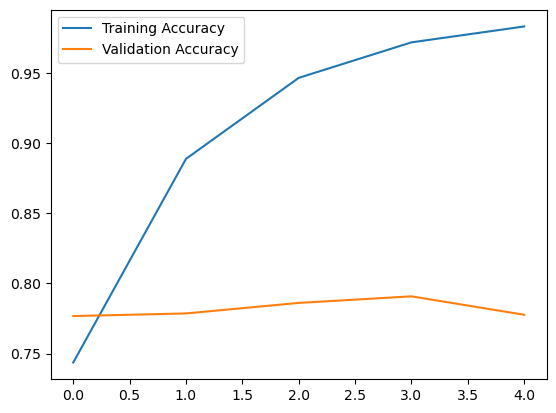

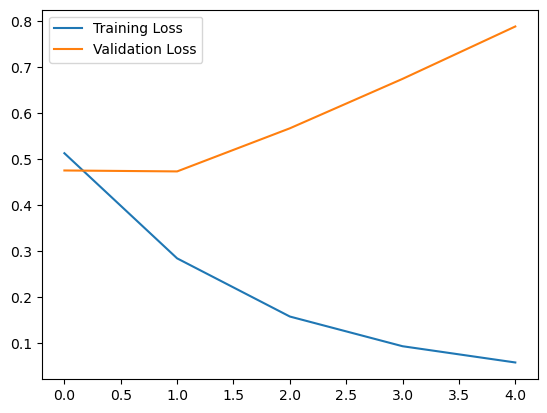

In [33]:
# Load the dataset
dataset = load_dataset("rotten_tomatoes")
train_dataset = dataset['train'] 
validation_dataset = dataset['validation']
test_dataset = dataset['test']

# Data augmentation functions
def synonym_replacement(sentence, n=3):
    words = sentence.split()
    new_words = words[:]
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0

    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break

    return ' '.join(new_words)

def random_insertion(sentence, n=3):
    words = sentence.split()
    for _ in range(n):
        new_synonym = wordnet.synsets(random.choice(words))
        if new_synonym:
            word = new_synonym[0].lemmas()[0].name()
            insert_position = random.randint(0, len(words))
            words.insert(insert_position, word)
    return ' '.join(words)

def random_deletion(sentence, p=0.3):
    words = sentence.split()
    if len(words) == 1:
        return sentence  # avoid deleting the only word

    new_words = [word for word in words if random.uniform(0, 1) > p]
    return ' '.join(new_words) if new_words else words[0]

def random_swap(sentence, n=3):
    words = sentence.split()
    if len(words) < 2:
        return sentence  # Return the sentence as-is if it has fewer than 2 words

    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

# Preprocess and augment data with labels
def preprocess_and_augment(dataset, labels):
    augmented_sentences = []
    augmented_labels = []

    for text, label in zip(dataset, labels):
        # Original sentence
        processed_sentence = ' '.join(simple_preprocess(text))
        augmented_sentences.append(processed_sentence)
        augmented_labels.append(label)

        # Apply augmentations
        augmented_sentences.append(synonym_replacement(processed_sentence))
        augmented_sentences.append(random_insertion(processed_sentence))
        augmented_sentences.append(random_deletion(processed_sentence))
        augmented_sentences.append(random_swap(processed_sentence))

        # Duplicate label for each augmentation
        augmented_labels.extend([label] * 4)

    return augmented_sentences, augmented_labels

train_texts, train_labels = preprocess_and_augment(train_dataset['text'], train_dataset['label'])

# Ensure all data sizes match after augmentation
assert len(train_texts) == len(train_labels)

# Tokenize and convert texts to sequences
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences([' '.join(simple_preprocess(text)) for text in validation_dataset['text']])
test_sequences = tokenizer.texts_to_sequences([' '.join(simple_preprocess(text)) for text in test_dataset['text']])

# Find max sentence length
max_sentence_length = max(len(seq) for seq in train_sequences)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_sentence_length, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=max_sentence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sentence_length, padding='post', truncating='post')

# Convert augmented labels to numpy array
train_labels = np.array(train_labels)
val_labels = np.array(validation_dataset['label'])
test_labels = np.array(test_dataset['label'])

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 to account for padding
embedding_dim = fasttext_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in tokenizer.word_index.items():
    if word in fasttext_model:
        embedding_matrix[idx] = fasttext_model[word]
    else:
        embedding_matrix[idx] = np.random.normal(size=(embedding_dim,))


# Instantiate and train the model
cnn_model = build_cnn_model(vocab_size, embedding_dim, embedding_matrix)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = cnn_model.fit(train_padded, train_labels, 
                        validation_data=(val_padded, val_labels),
                        batch_size=32, epochs=15, 
                        callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = cnn_model.evaluate(test_padded, test_labels)
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

# Plot accuracy and loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Upon further improving the model using data augmentation techniques, the `test accuracy is 0.78` and the `test loss is 0.44`. 